In [ ]:
# ! pip install numba
# ! pip install tqdm
# ! pip install ipywidgets
# ! pip install scikit-learn

In [ ]:
# NOT SURE THIS DOES ANYTHING
# Set a global random seed for reproducibility
np.random.seed(42)          # Your matriculation number

In [53]:
# EXECUTE THIS CELL

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from numba import njit
sns.set_context("notebook")


k_B = 1  # we use units of J/kT

@njit
def metropolis_step(lattice, J, H, T):
    L = lattice.shape[0]
    for _ in range(L * L):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        S = lattice[i, j]
        neighbors = (
            lattice[(i + 1) % L, j] + lattice[i, (j + 1) % L] +
            lattice[(i - 1) % L, j] + lattice[i, (j - 1) % L]
        )
        dE = 2 * S * (J * neighbors + H)

        if dE < 0 or np.random.rand() < np.exp(-dE / (k_B * T)):
            lattice[i, j] = -S


class IsingModel2D:

    def __init__(self, lattice_length, J=1, H=0, **kwargs):
        self.lattice_length = lattice_length
        self.J = J
        self.H = H
        self.initialize_lattice(**kwargs)

    @property
    def lattice(self):
        return self._lattice

    @property
    def N(self):
        return self.lattice_length**2

    @property
    def average_energy(self):
        return self.get_average_energy()

    @property
    def average_magnetization(self):
        return self.get_average_magnetization()

    @property
    def total_energy(self):
        return self.get_total_energy()

    @property
    def total_magnetization(self):
        return self.get_total_magnetization()

    def flip_site(self, i, j):
        self._lattice[i, j] *= -1

    def get_average_energy(self):
        return self.get_total_energy() / self.N

    def get_average_magnetization(self):
        return self.get_total_magnetization() / self.N

    def get_total_energy(self):
        lattice = self.lattice
        L = self.lattice_length
        J, H = self.J, self.H

        neighbors = (
            np.roll(lattice, 1, axis=0) +
            np.roll(lattice, -1, axis=0) +
            np.roll(lattice, 1, axis=1) +
            np.roll(lattice, -1, axis=1)
        )

        interaction_energy = -J * np.sum(lattice * neighbors) / 2
        field_energy = -H * np.sum(lattice)

        return interaction_energy + field_energy

    def get_total_magnetization(self):
        return np.sum(self.lattice)

    def initialize_lattice(self, random=False, spin=1):
        L = self.lattice_length
        if random:
            self._lattice = np.random.choice([-1, 1], size=(L, L))
        elif spin:
            self._lattice = np.full((L, L), spin, dtype=int)
        else:
            raise ValueError("Either lattice is initialized randomly or spin needs to be specified (-1 or 1)")

    def perform_metropolis_step(self, temperature):
        metropolis_step(self._lattice, self.J, self.H, temperature)

    def plot_lattice(self, colormap='viridis', title="2D Ising Model Configuration"):
        plt.imshow(self.lattice, cmap=colormap, interpolation='nearest', vmin=-1, vmax=1)
        plt.title(title)
        plt.show()
        return plt

    def run_monte_carlo_simulation(self,
                                   temperature,
                                   number_of_steps=1000,
                                   data_to_collect=['average_energy', 'average_magnetization'],
                                   plot_every_nstep=None,
                                   colormap='viridis',
                                   **kwargs):
        self.initialize_lattice(**kwargs)
        data = {key: [getattr(self, key)] for key in data_to_collect}

        for step_number in range(number_of_steps):
            if plot_every_nstep is not None:
                if step_number % plot_every_nstep == 0 and step_number != number_of_steps - 1:
                    plt.figure(figsize=(2, 2))
                    self.plot_lattice(colormap=colormap, title=f'Step {step_number}')

            self.perform_metropolis_step(temperature=temperature)

            for key in data_to_collect:
                data[key].append(getattr(self, key))

        return data


def compute_susceptibility(magnetizations, temperature, N):
    M_avg = np.mean(np.abs(magnetizations))
    M_sq_avg = np.mean(np.square(magnetizations))
    susceptibility = N * (M_sq_avg - M_avg ** 2) / (k_B * temperature)
    return susceptibility


def compute_specific_heat(energies, temperature, N):
    E_avg = np.mean(energies)
    E_sq_avg = np.mean(np.square(energies))
    specific_heat = N * (E_sq_avg - E_avg ** 2) / (k_B * temperature)
    return specific_heat

# Exercise: Monte Carlo Simulation for the 2D Ising Model

## Task a

Use the provided Monte Carlo simulation program to study the Ising model on a square lattice.

This model describes a two-dimensional system of spins that can take values of $\pm 1$, arranged on a grid where each spin interacts with its nearest neighbors and may be influenced by an external magnetic field.

The code uses the Metropolis algorithm to evolve the system toward thermal equilibrium at a given temperature and magnetic field. It returns key thermodynamic observables such as the mean energy, mean magnetization, magnetic susceptibility, and specific heat, based on statistical sampling after equilibration.
The system is initialized with all spins pointing up.

In the following code snippet:

- Set the lattice size to $L = 64$ (i.e., $N = L^2 = 4096$ spins).

- Set the external magnetic field $H = 0$.

- Choose a temperature $T = 10$ (in units of $J/k_B$).

- Set the number of Monte Carlo steps to $2000$.

Execute the cell.

Monitor the energy and magnetization: do they fluctuate around a stable average?

Observe the configuration of the spins at equilibrium: Is the orientation of the spins random such that the mean magnetization is approximately zero?

Estimate the typical size of a domain, i.e. a region where neighboring spins point in the same direction.

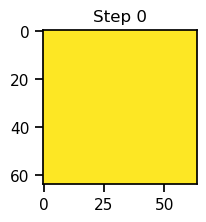

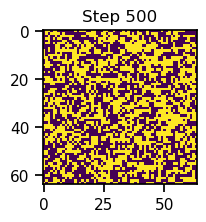

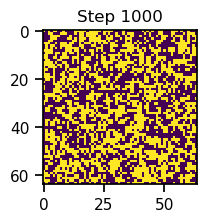

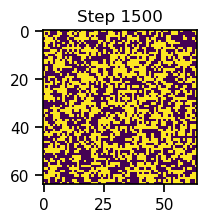

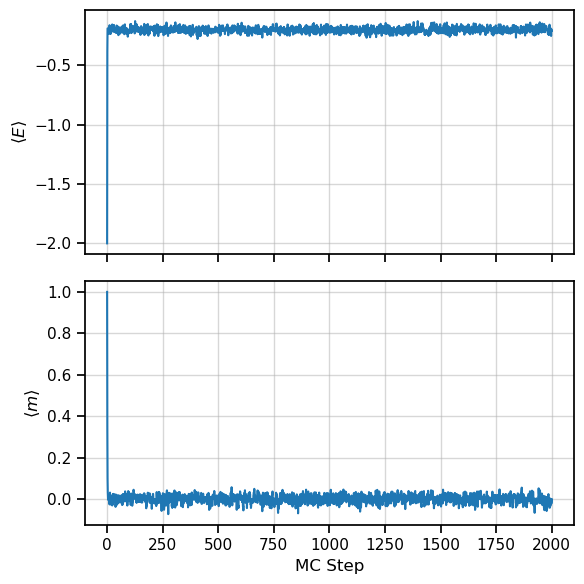

In [37]:
# === System-specific Parameters ===
L = 64              # Lattice length
temperature = 10    # Temperature
H = 0               # External magnetic field
J = 1               # Spin coupling coefficient
nsteps = 2000       # Number of Monte Carlo steps


# === Simulation ===
model = IsingModel2D(lattice_length=L,J=J,H=H)
simulation_data = model.run_monte_carlo_simulation(temperature=temperature, number_of_steps=nsteps, plot_every_nstep=500)

energies = simulation_data['average_energy']
magnetizations = simulation_data['average_magnetization']
steps = range(len(energies))

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)  # 1 row, 2 columns

# Plot Energy
sns.lineplot(x=steps, y=energies, ax=axes[0])
axes[0].set_xlabel('MC Step')
axes[0].set_ylabel(r'$\langle E \rangle$')
axes[0].grid(alpha=0.5)

# Plot Magnetization
sns.lineplot(x=steps, y=magnetizations, ax=axes[1])
axes[1].set_xlabel('MC Step')
axes[1].set_ylabel(r'$\langle m \rangle$')
axes[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

<details>
<summary>Solution (to be removed)</summary>

At high temperatures, such as $T=10$, thermal fluctuations dominate and the spin orientations become effectively random due to entropic effects. As a result, the mean magnetization is approximately zero. The system is in the paramagnetic phase, and no stable spin domains are observed.
</details> 

## Task b

Choose a low temperature, such as $T = 0.5$: Are the spins still randomly oriented, or does a majority tend to align in a preferred direction?

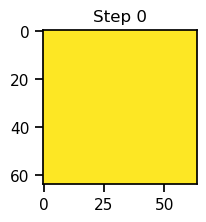

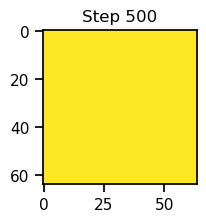

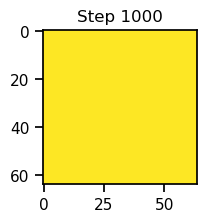

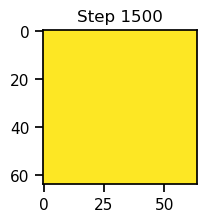

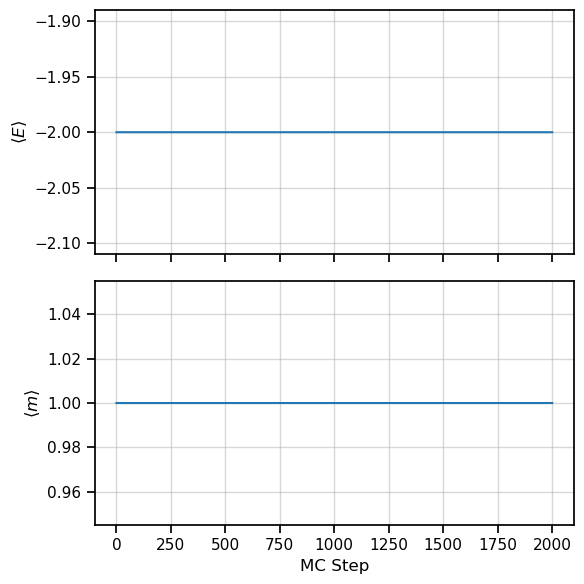

In [41]:
# === System-specific Parameters ===
L = 64              # Lattice length
temperature = 0.5    # Temperature
H = 0               # External magnetic field
J = 1               # Spin coupling coefficient
nsteps = 2000       # Number of Monte Carlo steps


# === Simulation ===
model = IsingModel2D(lattice_length=L,J=J,H=H)
simulation_data = model.run_monte_carlo_simulation(temperature=temperature, number_of_steps=nsteps, plot_every_nstep=500)

energies = simulation_data['average_energy']
magnetizations = simulation_data['average_magnetization']
steps = range(len(energies))

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)  # 1 row, 2 columns

# Plot Energy
sns.lineplot(x=steps, y=energies, ax=axes[0])
axes[0].set_xlabel('MC Step')
axes[0].set_ylabel(r'$\langle E \rangle$')
axes[0].grid(alpha=0.5)

# Plot Magnetization
sns.lineplot(x=steps, y=magnetizations, ax=axes[1])
axes[1].set_xlabel('MC Step')
axes[1].set_ylabel(r'$\langle m \rangle$')
axes[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

## Task c

You have previously observed that the magnetization vanishes on average ($\langle m \rangle \approx 0$) at high temperatures and becomes non-zero ($$\langle m \rangle \neq 0$) at low temperatures. This implies the existence of a critical temperature $T_c$ where a phase transition occurs. In the case of a square lattice, the exact solution by Lars Onsager (1944) yields:

$$
\sinh \left( \frac{2J}{k_B T_c} \right) = 1 \quad \implies \quad T_c \approx 2.269
$$


You will now cool the system gradually to observe this phase transition numerically.
Set:

- Lattice size to $L = 128$.

- Initial temperature: $T = 4$.

- Final temperature: $T = 1.5$. 

- Temperature step: $\Delta T = 0.25$.

- Equilibrate the system for at least $1000$ Monte Carlo steps before collecting data.

Execute the cell to perform the temperature sweep and generate a graphical summary of the thermodynamic observables as a function of temperature. The plots will help you identify $T_c$ and assess the nature of the transition.

- Study the following quantities:

   - Mean energy per spin $E$.
   - Magnetization per spin $m$.  
   - Magnetic susceptibility $\chi$.
   - Specific heat $C_V$.


The observables $\chi$ and $C_V$ are computed using fluctuation formulas:

$$
\chi = \frac{\langle M^2 \rangle - \langle |M| \rangle^2}{k_B T}
\quad\text{and}\quad
C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_B T^2}.
$$

Using the absolute value ⟨$|M|$⟩ in the computation of $\chi$ is a well-established workaround to get meaningful statistics in small systems, where the magnetization can spontaneously flip signs due to thermal fluctuations.

Simulating temperatures:   0%|          | 0/10 [00:00<?, ?it/s]

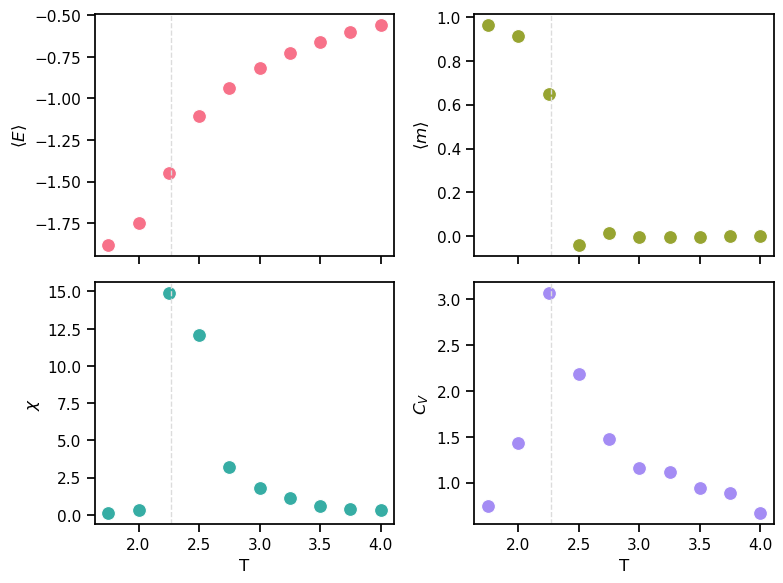

In [45]:
# === System-specific Parameters ===
L = 128                          # Lattice length
J = 1                           # Spin coupling coefficient
H = 0                           # External magnetic field
initial_temperature = 4         
final_temperature = 1.5
temperature_interval = 0.25
eq_steps = 1000                 # Equilibration steps
nsteps = 2000                   # Total number of Monte Carlo steps


# === Simulation ===
data = {
    'T': [],
    '$ \langle E \\rangle $': [],
    '$ \langle m \\rangle $': [],
    '$\chi$': [],
    '$C_V$': []
}

model = IsingModel2D(lattice_length=L, J=J, H=H)

temperature_range = np.arange(initial_temperature, final_temperature, -temperature_interval)

for T in tqdm(temperature_range, desc="Simulating temperatures"):
    simulation_data = model.run_monte_carlo_simulation(
        temperature=T,
        number_of_steps=nsteps,
        plot_every_nstep=None,
        data_to_collect=['average_energy', 'average_magnetization'],
        random=False, spin=1
    )

    # Post-equilibration values
    E_equilibrated = simulation_data['average_energy'][eq_steps:]
    M_equilibrated = simulation_data['average_magnetization'][eq_steps:]

    # Append only equilibrated values
    data['T'].append(T)
    data['$ \langle E \\rangle $'].append(np.mean(E_equilibrated))
    data['$ \langle m \\rangle $'].append(np.mean(M_equilibrated))
    data['$\chi$'].append(
        compute_susceptibility(
            magnetizations=M_equilibrated,
            temperature=T, N=model.N
        )
    )
    data['$C_V$'].append(
        compute_specific_heat(
            energies=E_equilibrated,
            temperature=T, N=model.N
        )
    )

# Create DataFrame and plot
df = pd.DataFrame(data)
df.set_index("T", inplace=True)

colors = sns.color_palette("husl", n_colors=len(df.columns))
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
axes = axes.flatten()

for ax, column, color in zip(axes, df.columns, colors):
    sns.scatterplot(data=df, x=df.index, y=column, ax=ax, color=color, s=100)
    ax.axvline(x=2.269, color='gainsboro', linestyle='--', linewidth=1)
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

<details>
<summary>Solution (to be removed)</summary>

To address this task, we performed Monte Carlo simulations of the 2D Ising model at various constant temperatures. After allowing the system to equilibrate for 1000 Monte Carlo steps, we calculated the mean magnetization per spin, the magnetic susceptibility, the internal energy, and the heat capacity.

The results show good agreement with the exact solution for the spontaneous magnetization in the thermodynamic limit. As expected, the magnetization, serving as the*order parameter, vanishes at the critical temperature $T_C \approx 2.269$, signaling a phase transition from a ferromagnetic to a paramagnetic phase.

The magnetic susceptibility and the heat capacity at constant volume ($C_V$) are computed from the fluctuations of magnetization and energy, respectively, according to the fluctuation-dissipation theorem:

$$
\chi = \frac{\langle M^2 \rangle - \langle |M| \rangle^2}{k_B T}
\quad\text{and}\quad
C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_B T^2}
$$

Note: We compute $C_V$, not $C_P$, since the volume (i.e., the number of spins or lattice size) is fixed in the simulation.

The temperature dependence of the order parameter $m$ provides clear evidence of a phase transition. To determine the order of the transition, we examine the behavior of the heat capacity. The heat capacity exhibits a divergence (or a sharp peak in finite systems) at $T_C$, indicating a continuous (second-order) phase transition. This is consistent with the known behavior of the 2D Ising model, which undergoes a second-order phase transition with no latent heat and a diverging correlation length at criticality.

</details> 

## Task d

At the critical temperature $T = T_C$, a ferromagnet exhibits critical behavior characterized by a power-law relationship between the spontaneous magnetization $m = \langle M \rangle$ and the external magnetic field $H$. This relationship defines the critical exponent $\delta$:

$$
m = D H^{1/\delta}
$$

To determine $\delta$, we perform a set of canonical Monte Carlo simulations at the critical temperature $T = T_C = 2.269$, using a range of small external magnetic field strengths. After reaching equilibrium in each case, we measure the magnetization per spin $m$.

- Set the temperature to $T = T_C \approx 2.269$ and choose a system size of $L = 128$.

- Define a list of external fields: $H = 0.01,\ 0.02,\ 0.04,\ 0.06,\ 0.08,\ 0.10,\ 0.12,\ 0.14,\ 0.16$.

- Equilibrate the system for at least $1000$ Monte Carlo steps before collecting data.

- Set the total number of Monte Carlo steps to $5000$.

Execute the cell to perform the simulations and create a log-log plot of $m$ versus $H$. Estimate the critical exponent $\delta$.

Scanning magnetic fields:   0%|          | 0/9 [00:00<?, ?it/s]

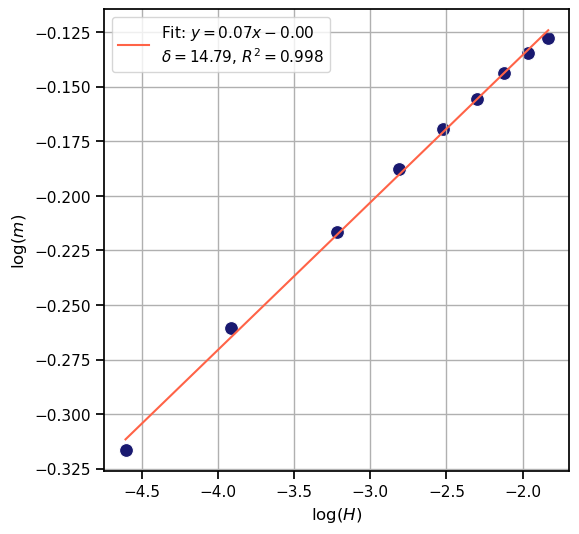

In [50]:
# === System-specific Parameters ===
L = 128                                         # Lattice length
J = 1                                           # Spin coupling coefficient
magnetic_fields = [0.01,
                   0.02,
                   0.04,
                   0.06,
                   0.08,
                   0.10,
                   0.12,
                   0.14,
                   0.16]    # External magnetic field H
temperature = 2.269                             # Temperature
eq_steps = 1000                                 # Equilibration steps
nsteps = 5000                                  # Number of Monte Carlo steps



# === Simulation ===
magnetic_data = {
    'magnetic_fields': magnetic_fields,
    'magnetizations': []
}

for H in tqdm(magnetic_fields, desc="Scanning magnetic fields"):
    model = IsingModel2D(lattice_length=L, J=J, H=H)
    simulation_data = model.run_monte_carlo_simulation(
        temperature=temperature,
        number_of_steps=nsteps,
        data_to_collect=['average_magnetization'],
        random=False, spin=1
    )

    M_equilibrated = simulation_data['average_magnetization'][eq_steps:]
    magnetic_data['magnetizations'].append(np.mean(M_equilibrated))

df_magnetic = pd.DataFrame(magnetic_data)


# Sample data
x = np.log(df_magnetic['magnetic_fields'].values)
y = np.log(df_magnetic['magnetizations'].values)

# Define linear model for curve_fit
def linear_model(x, a, b):
    return a * x + b

# Fit model
params, _ = curve_fit(linear_model, x, y)
slope, intercept = params
delta = 1 / slope

# Generate fitted line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = linear_model(x_fit, slope, intercept)

# Compute R^2
y_pred = linear_model(x, slope, intercept)
r_squared = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(6, 6)) 
sns.scatterplot(x=x, y=y, s=100, color="midnightblue")
sns.lineplot(x=x_fit, y=y_fit, color="tomato", 
             label=fr"Fit: $y = {slope:.2f}x {intercept:+.2f}$" + 
                   f"\n$\\delta = {delta:.2f}$, $R^2 = {r_squared:.3f}$")

plt.xlabel(r"$\log(H)$")
plt.ylabel(r"$\log(m)$")
plt.legend()
plt.grid(True)
plt.show()

<details>
<summary>Solution (to be removed)</summary>

By plotting $\log(m)$ versus $\log(H)$, the data should approximately follow a straight line, from which we extract the slope $a$. The inverse of this slope yields the critical exponent:

$$
\frac{1}{\delta} = a \quad \implies \quad \delta = \frac{1}{a}
$$

For the two-dimensional Ising model, the exact solution in the thermodynamic limit ($L \to \infty$) gives:

$$
\delta = 15
$$

However, for finite-size systems, deviations from the theoretical value are expected due to finite-size effects. The accuracy of your fitted $\delta$ will improve with larger system sizes and sufficient equilibration.


</details> 